<a href="https://colab.research.google.com/github/shivaansh81001/cmput-466-mini-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datascience import *
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [47]:
RANDOM_SEED = 6969

TRAIN_PERC=0.6
VAL_PERC=0.2
TEST_PERC=0.2

np.random.seed(RANDOM_SEED)

TRAINING_SIZE=[0.1, 0.3, 0.5, 0.7, 1]

In [48]:
#test imports
arr=[0,1,2,3,4,5,6,7,8,9]
print("numpy working ",np.array(arr))
print("pandas working ",pd.array(arr))
Table().with_column("test",np.array(arr)).show(1)


numpy working  [0 1 2 3 4 5 6 7 8 9]
pandas working  <IntegerArray>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Length: 10, dtype: Int64


test
0


In [49]:
data=Table().read_table('cumulative.csv')
##data.show(5)
data=data.drop(["koi_tce_delivname","koi_pdisposition","kepler_name","rowid","kepid","kepoi_name","koi_teq_err1","koi_teq_err2","koi_score"])

for col in data.labels:
  data=data.where(col,are.not_equal_to('nan'))
  data=data.where(col,are.not_equal_to(float(np.nan)))

#print(type(data.take(99).column('koi_tce_plnt_num')[0]),data.take(99).column('koi_tce_plnt_num')[0])

#data.show(4)

In [50]:
data=data.to_df().dropna()
data=Table().from_df(data)

#data.group('koi_disposition').show(5)
#data.show(10)
num_false=data.where('koi_disposition',are.equal_to('FALSE POSITIVE')).num_rows


false_data=data.where('koi_disposition',are.equal_to('FALSE POSITIVE')).sample(k=int(0.5*num_false))
##false_data.show(3)


confirmed_data=data.where('koi_disposition',are.equal_to('CONFIRMED'))
#confirmed_data.show(3)

data= false_data.append(confirmed_data).shuffle()
data=data.shuffle()


target = (data.column("koi_disposition")=="CONFIRMED").astype(int)
X = data.drop("koi_disposition").to_df()

In [51]:
def generate_report(t_true,t_pred):
  return {
        'Accuracy': accuracy_score(t_true, t_pred),
        'Precision': precision_score(t_true, t_pred),
        'Recall': recall_score(t_true, t_pred),
        'F1-Score': f1_score(t_true, t_pred)
    }

In [52]:
def get_accuracy(t, t_hat):
    """
    Calculate accuracy,
    """
    #print(t,t_hat)
    acc=np.mean(t==t_hat)*100
    #print("accuracy",acc)
    return acc

In [53]:
def baseline_model(X_test,t_test):
  k = len(np.unique(t_test))
  #print(k)
  np.random.seed(RANDOM_SEED)
  t_hat=np.random.choice(np.unique(t_test),size=len(X_test),replace=True)

  return t_hat


In [54]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -400, 400)))

def train_logistic_regression(X, t):
    """
    Given data, train your logistic classifier.
    Return weight and bias

    """

    m,n=X.shape
    w=np.zeros(n)
    b=0

    for i in range(1000):
        z=np.dot(X,w)+b
        t_hat=sigmoid(z)
        dw=(1/m)*np.dot(X.T,(t_hat-t))
        db=(1/m)*np.sum(t_hat-t)
        w-=0.1*dw
        b-=0.1*db
    #print(w,b)

    return w, b

def predict_logistic_regression(X, w, b):
    """
    Generate predictions by your logistic classifier.
    """
    temp=1/(1+np.exp(-(X@w+b)))
    t=(temp>=0.5).astype(int)
    return t

In [64]:
def train_SVM(X_train,t_train):
  param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']

  }
  cv_folds = max(2, min(5, len(X_train)))
  grid = GridSearchCV(SVC(), param_grid, cv=cv_folds, scoring='accuracy')
  grid.fit(X_train, t_train)
  return grid

def predict_SVM(model_fit,X_val):
  t_hat=model_fit.predict(X_val)
  return t_hat


In [56]:
def train_MLP(X_train,t_train):
  mlp=MLPClassifier(hidden_layer_sizes=(64,32),activation='relu', max_iter=300, random_state=42)
  mlp.fit(X_train,t_train)
  return mlp

def predict_MLP(mlp,X_val):
  t_hat=mlp.predict(X_val)
  return t_hat


In [71]:
%matplotlib inline
def plots(name,train_acc, val_acc):
    plt.figure()
    plt.plot(TRAINING_SIZE, train_acc, label="Training Accuracy", marker='o')
    plt.plot(TRAINING_SIZE, val_acc, label="Validation Accuracy", marker='o')
    plt.title(f"Train vs Validation Curve - {name}")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()



In [58]:
total_rows=len(target)

X_train, X_temp, t_train, t_temp = train_test_split(X, target, test_size=(1 - TRAIN_PERC), random_state=RANDOM_SEED,stratify=target)
X_val, X_test, t_val, t_test = train_test_split(X_temp, t_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=t_temp)

__________This is run 0.1__________


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


__________This is run 0.3__________


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


__________This is run 0.5__________


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


__________This is run 0.7__________


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


__________This is run 1__________
Accuracy of baseline on test set:  49.8316498316
           Test Set
Accuracy   0.498316
Precision  0.508368
Recall     0.534066
F1-Score   0.520900


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Overall Accuracy of logistic regression on validation set:  69.5505617978
Overall Accuracy of logistic regression on test set:  69.2480359147
           Validation Set  Test Set
Accuracy         0.695506  0.692480
Precision        0.627615  0.624828
Recall           0.991189  0.995604
F1-Score         0.768574  0.767797
Overall Accuracy of SVM on validation set:  63.2584269663
Overall Accuracy of SVM on test set:  64.4219977553
           Validation Set  Test Set
Accuracy         0.632584  0.644220
Precision        0.581306  0.589378
Recall           1.000000  1.000000
F1-Score         0.735223  0.741646
Overall Accuracy of MLP on validation set:  86.7415730337
Overall Accuracy of MLP on test set:  87.5420875421
           Validation Set  Test Set
Accuracy         0.867416  0.875421
Precision        0.956522  0.967391
Recall           0.775330  0.782418
F1-Score         0.856448  0.865128
[78.651685393258433, 81.772784019975035, 72.059925093632955, 72.858672376873656, 68.27715355805243

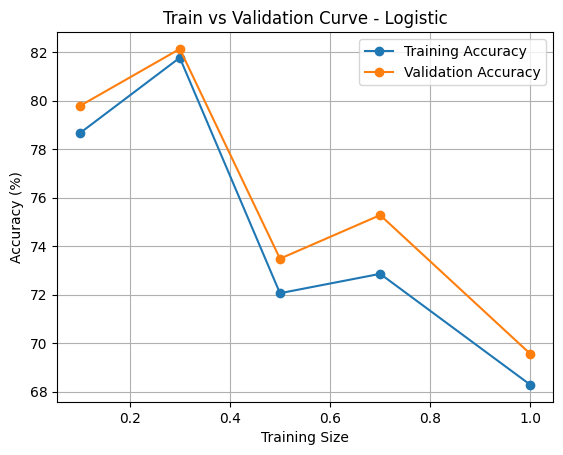

[100.0, 100.0, 100.0, 100.0, 100.0]
[52.134831460674157, 55.393258426966298, 57.19101123595506, 60.0, 63.258426966292134]


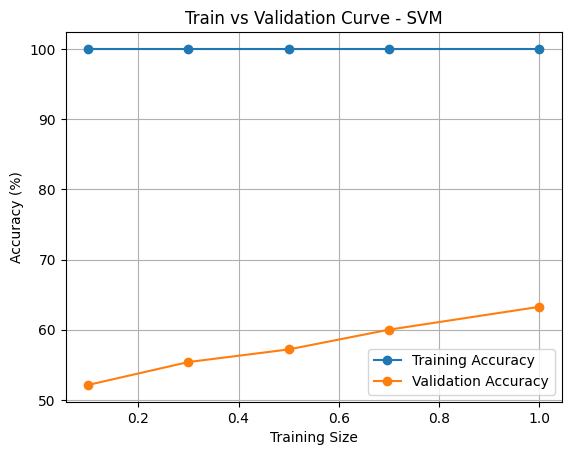

[86.516853932584269, 83.146067415730343, 89.887640449438194, 87.79443254817987, 87.116104868913851]
[84.831460674157299, 85.056179775280896, 88.426966292134836, 87.977528089887642, 86.741573033707866]


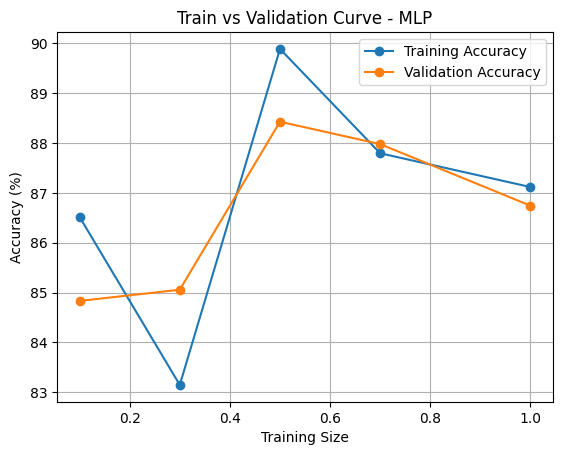

In [73]:
def main():

  train_acc_logs = []
  val_acc_logs = []

  train_acc_svms = []
  val_acc_svms = []

  train_acc_mlps = []
  val_acc_mlps = []

  for size in TRAINING_SIZE:
    print(f'__________This is run {size}__________')
    if size!=1:
      X_subset, _, t_subset, _ = train_test_split(X_train, t_train, train_size=size, random_state=RANDOM_SEED)
    else:
      X_subset,t_subset = X_train,t_train


    ##################### BASELINE #####################
    t_hat_test_base=baseline_model(X_test,t_test)
    if size==1:
      print("Accuracy of baseline on test set: ", get_accuracy(t_hat_test_base, t_test))
      print(pd.DataFrame({
          "Test Set": generate_report(t_test,t_hat_test_base)
                            }))
    ##################### BASELINE #####################



    ##################### LOGISTIC REGRESSION #####################
    w_log, b_log = train_logistic_regression(X_subset, t_subset)

    t_hat_train_log=predict_logistic_regression(X_subset, w_log, b_log)
    t_hat_val_log = predict_logistic_regression(X_val, w_log, b_log)
    t_hat_test_log = predict_logistic_regression(X_test, w_log, b_log)

    if size==1:
      print("Overall Accuracy of logistic regression on validation set: ", get_accuracy(t_hat_val_log, t_val))
      print("Overall Accuracy of logistic regression on test set: ", get_accuracy(t_hat_test_log, t_test))
      print(pd.DataFrame({
          "Validation Set": generate_report(t_val, t_hat_val_log),
          "Test Set": generate_report(t_test,t_hat_test_log)
                            }))
    train_acc_logs.append(get_accuracy(t_hat_train_log, t_subset))
    val_acc_logs.append(get_accuracy(t_hat_val_log, t_val))
    ##################### LOGISTIC REGRESSION #####################



    ##################### SVM #####################
    model_fit = train_SVM(X_subset,t_subset)

    t_hat_svm_train = predict_SVM(model_fit, X_subset)
    t_hat_svm_val =predict_SVM(model_fit,X_val)
    t_hat_svm_test= predict_SVM(model_fit,X_test)

    if size==1:
      print("Overall Accuracy of SVM on validation set: ", get_accuracy(t_hat_svm_val, t_val))
      print("Overall Accuracy of SVM on test set: ", get_accuracy(t_hat_svm_test, t_test))
      print(pd.DataFrame({
          "Validation Set": generate_report(t_val, t_hat_svm_val),
          "Test Set": generate_report(t_test,t_hat_svm_test)
                            }))
    train_acc_svms.append(get_accuracy(t_hat_svm_train, t_subset))
    val_acc_svms.append(get_accuracy(t_hat_svm_val, t_val))
    ##################### SVM #####################



    ##################### MLP #####################
    mlp= train_MLP(X_subset,t_subset)

    t_hat_mlp_train=predict_MLP(mlp,X_subset)
    t_hat_mlp_val=predict_MLP(mlp,X_val)
    t_hat_mlp_test= predict_MLP(mlp,X_test)

    if size==1:
      print("Overall Accuracy of MLP on validation set: ", get_accuracy(t_hat_mlp_val, t_val))
      print("Overall Accuracy of MLP on test set: ", get_accuracy(t_hat_mlp_test, t_test))
      print(pd.DataFrame({
          "Validation Set": generate_report(t_val, t_hat_mlp_val),
          "Test Set": generate_report(t_test,t_hat_mlp_test)
                            }))
    train_acc_mlps.append(get_accuracy(t_hat_mlp_train, t_subset))
    val_acc_mlps.append(get_accuracy(t_hat_mlp_val, t_val))
  ##################### SVM #####################

  print(train_acc_logs)
  print(val_acc_logs)
  plots("Logistic",train_acc_logs,val_acc_logs)


  print(train_acc_svms)
  print(val_acc_svms)
  plots("SVM",train_acc_svms,val_acc_svms)

  print(train_acc_mlps)
  print(val_acc_mlps)
  plots("MLP",train_acc_mlps,val_acc_mlps)

main()